# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
import equinox as eqx
from jax import Array, config
import jax.numpy as jnp
from jax.tree_util import Partial
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [4]:
from controllers import RandomController, SumOfSinusoids, LinearPolicy, SumOfGaussians
from model_learning.gp_models import MGPR

In [5]:
import optax as ox

from typing import Tuple

In [6]:
from IPython import display

# Functions

In [7]:
def cart_pole_cost(
    states_sequence: ArrayLike, 
    target_state: ArrayLike = jnp.array([jnp.pi,0.0]), 
    lengthscales: ArrayLike = jnp.array([3.0,1.0]),
    angle_index:int = 2,
    pos_index:int = 0
)->Array:
    """
    Cost function given by the combination of the saturated distance between |theta| and 'target angle', and between x and 'target position'.
    """
    x = states_sequence[pos_index]
    xdot = states_sequence[pos_index+1]
    theta = states_sequence[angle_index]
    theta_dot = states_sequence[angle_index+1]

    target_x = target_state[1]
    target_theta = target_state[0]

    return 1 - jnp.exp(
        -(jnp.square((jnp.abs(theta) - target_theta) / lengthscales[0])) - jnp.square((x - target_x) / lengthscales[1]) -jnp.square(theta_dot) - jnp.square(xdot)
    )

In [8]:
# def cart_pole_cost(
#     states_sequence: ArrayLike, 
#     target_state: ArrayLike = jnp.array([0.0,jnp.pi,0.0, 0.0]), 
# )->Array:
#     """
#     Cost function given by the combination of the saturated distance between 
#     |theta| and 'target angle', and between x and 'target position'.
#     """
#     #cart_pos, pole_angle, cart_velocity, angle_velocity, _ = states_sequence
#     target_theta, target_cart_velocity, target_theta_dot = target_state[1:]

#     # We just want the cart to be at rest with the pole vertical and no angular velocity

#     # return (
#     #     np.square(pole_angle - target_theta) + jnp.square(cart_velocity - target_cart_velocity) + jnp.square(angle_velocity-target_theta_dot)
#     # )
#     return (
#         np.square(states_sequence[1] - target_theta) + jnp.square(states_sequence[2] - target_cart_velocity) + jnp.square(states_sequence[3]-target_theta_dot)
#     )

In [38]:
def fit_controller(  # noqa: PLR0913
    *,
    policy: eqx.Module,
    samples: ArrayLike,
    timesteps: ArrayLike,
    gp_model: eqx.Module,
    optim: ox.GradientTransformation,
    key: ArrayLike = jr.PRNGKey(42),
    num_iters: int = 100,
    unroll: int = 5,
)->Tuple[eqx.Module,Array]:
    """The optimization loop for fitting the policy parameters."""
    @eqx.debug.assert_max_traces(max_traces=1)
    def rollout(
        policy: eqx.Module,
        init_samples: ArrayLike,
        model: eqx.Module,
        timesteps: ArrayLike,
        key: ArrayLike = jr.key(123),
    )->float:
        policy_params, policy_static = eqx.partition(policy, eqx.is_array)
        
        def one_rollout_step(carry, t):
            policy_params, key, samples, total_cost = carry
            policy = eqx.combine(policy_params, policy_static)
            actions = jax.vmap(policy)(samples,jnp.tile(t,num_particles))
        
            key, subkey = jr.split(key)
            samples = model.get_samples(key, samples, actions, 1)
            cost = jnp.sum(jax.vmap(cart_pole_cost)(jnp.hstack((samples, actions))))
            return (policy_params,key,samples,total_cost+cost), cost
        
        total_cost = 0
        (policy_params,key,samples,total_cost), result = jax.lax.scan(
            one_rollout_step, (policy_params,key,init_samples,total_cost), timesteps
        )
        return total_cost/len(timesteps)
    
    opt_state = optim.init(eqx.filter(policy,eqx.is_array))
    
    # Mini-batch random keys to scan over.
    iter_keys = jr.split(key, num_iters)
    
    # Optimisation step.
    @eqx.filter_jit
    def make_step(
        policy: eqx.Module,
        opt_state: PyTree,
    )->Tuple[eqx.Module,PyTree, float]:
        loss_value, loss_gradient = eqx.filter_value_and_grad(rollout)(policy,samples,gp_model,timesteps)
        updates, opt_state = optim.update(loss_gradient, opt_state, eqx.filter(policy, eqx.is_array))
        policy = eqx.apply_updates(policy, updates)
        return policy, opt_state, loss_value
    
    # Optimisation loop - hack an early stopping criteron
    best_loss: float = float("inf")
    patience: int = 5  # Number of steps of no improvement before stopping
    patience_count: int = 0  # Number of steps since last improving update.
    min_delta: float = (
        1e-3  # Minimum delta between updates to be considered an improvement
    )
    for step in range(num_iters):
        policy, opt_state, train_loss = make_step(policy, opt_state)
        # patience_count = jax.lax.select(
        #     best_loss - train_loss > min_delta, 0, patience_count + 1
        # )
        # best_loss = jax.lax.select(train_loss < best_loss, train_loss, best_loss)
        #print(f"{step=}, train_loss={train_loss.item()}, best_loss={best_loss.item()}, ")
        # if patience_count > patience:
        #     print(f"Terminating due to early stopping at {step=}, train_loss={train_loss.item()}, ")
        #     break
        if (step % 100) == 0 or (step == num_iters - 1):
            print(f"{step=}, train_loss={train_loss.item()}, ")

    return policy

## Globals

In [10]:
num_particles = 400

In [11]:
num_trials = 5
T_sampling = 0.05
T_exploration = 0.35
T_control = 3.0
sim_timestep = 0.01

## Generate the environments

In [12]:
env = gym.make("InvertedPendulum-v5")
env_test = gym.make("InvertedPendulum-v5", render_mode='rgb_array')

In [13]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0]
num_basis = 200
umax = 3.0

In [14]:
# Initialize a random controller
exploration_policy = RandomController(state_dim,action_dim,True,3.0)

In [19]:
# Randomly sample some points
key = jr.key(42)
x, _ = env.reset()
states = [x]
key, subkey = jr.split(key)
u = env.action_space.sample()
#u = exploration_policy(x,0,subkey)
actions = [u]

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env.step(np.array(u))
    x = z[0]
    states.append(x)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    #u = exploration_policy(x,timestep,subkey)
    actions.append(u)

for _ in range(9):
    x, _ = env.reset()
    states.append(x)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    #u = exploration_policy(x,0,subkey)
    actions.append(u)
    
    for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
        z = env.step(np.array(u))
        x = z[0]
        states.append(x)
        key, subkey = jr.split(key)
        u = env.action_space.sample()
        #u = exploration_policy(x,timestep,subkey)
        actions.append(u)
    

In [20]:
jnp.hstack((jnp.array(states),jnp.array(actions))).shape

(370, 5)

In [21]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))

In [22]:
-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0])

Array(108.24850431, dtype=float64)

In [23]:
%%time
model.optimize()

CPU times: user 13 s, sys: 1.57 s, total: 14.6 s
Wall time: 4.33 s


In [24]:
-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0])

Array(-222.42283676, dtype=float64)

In [26]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack(st,jnp.array(actions))))

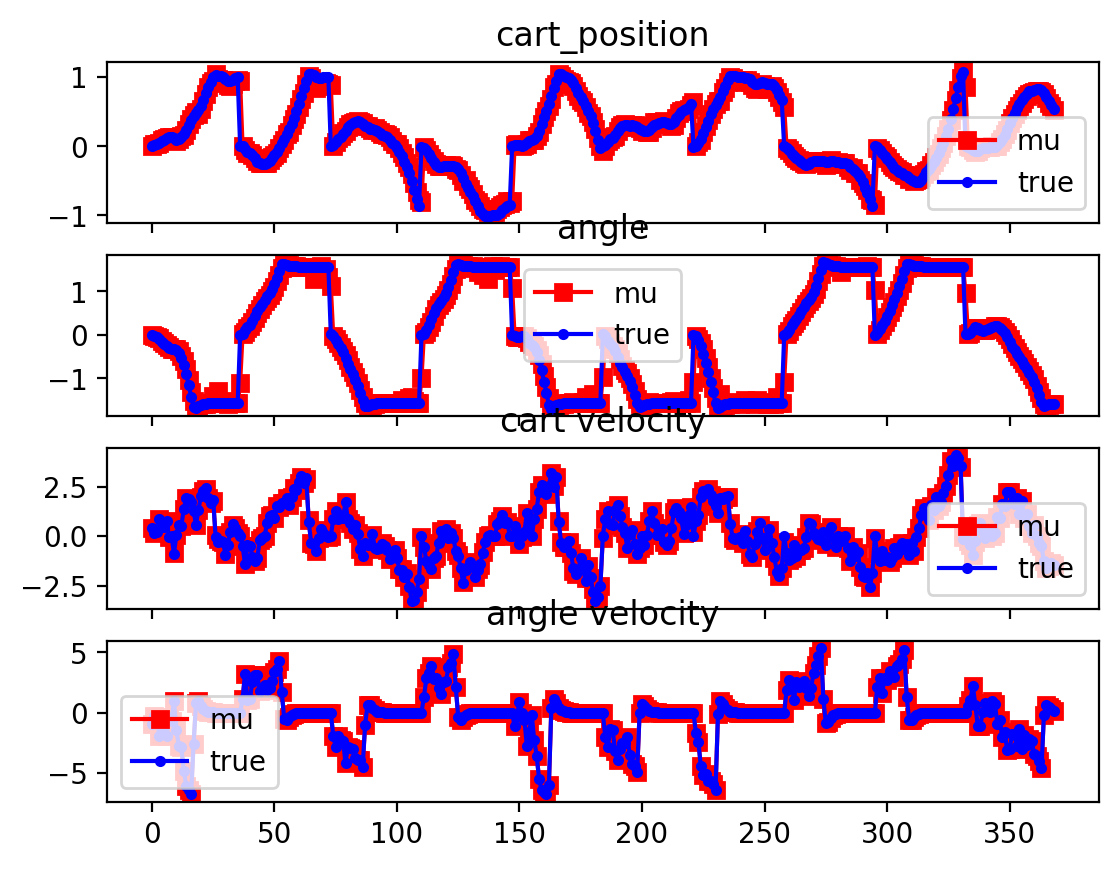

In [27]:
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

### Rollout

In [28]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial action
u = exploration_policy(x,timestep,subkey)

In [29]:
# initialize some particles
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [30]:
from controllers import RandomController, SumOfSinusoids, LinearPolicy, SumOfGaussians#, SumOfGaussiansWithAngles

In [31]:
explore_policy = SumOfSinusoids(
    state_dim,
    action_dim,
    num_sin=10, 
    omega_min=0.1*(2*jnp.pi),
    omega_max=2.0*(2*jnp.pi),
    amplitude_min=0.1*umax,
    amplitude_max=0.1*umax,
    to_squash=True, 
    max_action=umax,key=key
)
num_basis = 200
control_policy = SumOfGaussians(
    state_dim, 
    action_dim, 
    num_basis, 
    initial_log_lengthscales = None,
    initial_centers=None,
    to_squash=True, 
    max_action=umax)

In [32]:
control_horizon = int(T_control/T_sampling)

In [33]:
optimizer = ox.adam(learning_rate=ox.linear_schedule(init_value=1e-2, end_value=1e-6, transition_steps=100))

In [39]:
%%time
control_policy = fit_controller(
    policy=control_policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=1000
)

step=0, train_loss=390.9742626894268, 
step=100, train_loss=384.5886801141161, 
step=200, train_loss=384.58745810962745, 
step=300, train_loss=384.58583917661264, 
step=400, train_loss=384.5838730494574, 
step=500, train_loss=384.5815847324368, 
step=600, train_loss=384.57898737245966, 
step=700, train_loss=384.57608749519676, 
step=800, train_loss=384.5728869053511, 
step=900, train_loss=384.5693849702683, 
step=999, train_loss=384.56561837218584, 
CPU times: user 19min 46s, sys: 21min 31s, total: 41min 17s
Wall time: 6min 33s


In [40]:
control_policy.log_lengthscales

Array([[-0.14167806, -0.05113283, -0.09703482, -0.16592275]], dtype=float64)

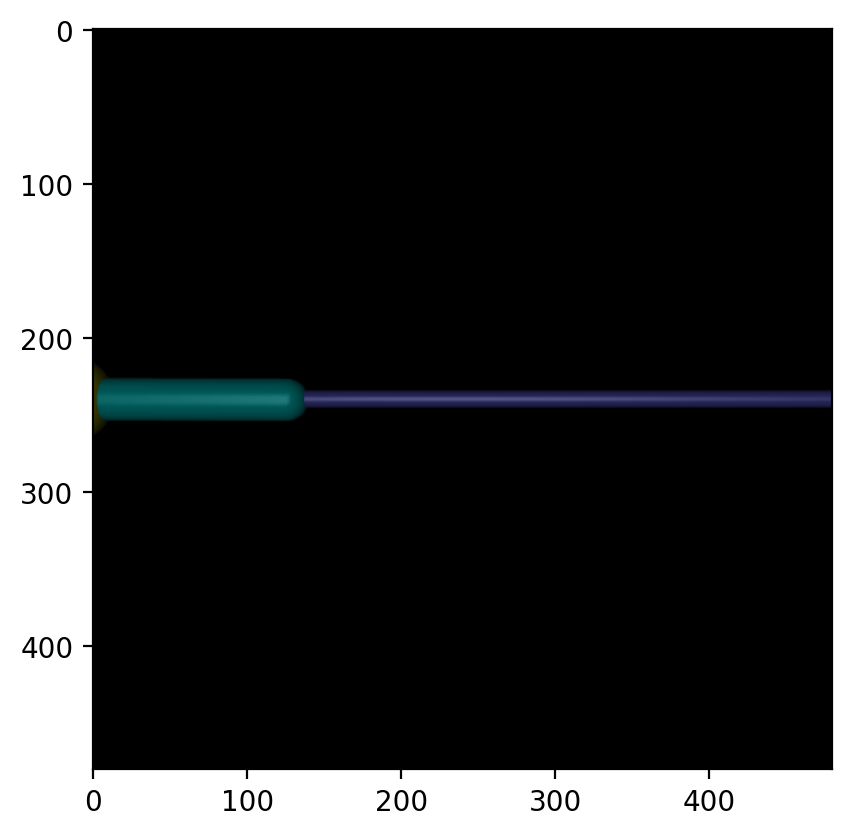

In [62]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [42]:
%%time
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

76.78326856313114
-257.9516550195401
CPU times: user 21.3 s, sys: 2.5 s, total: 23.8 s
Wall time: 7.34 s


## Visualize how weell the model is predicting the next state

TO DO

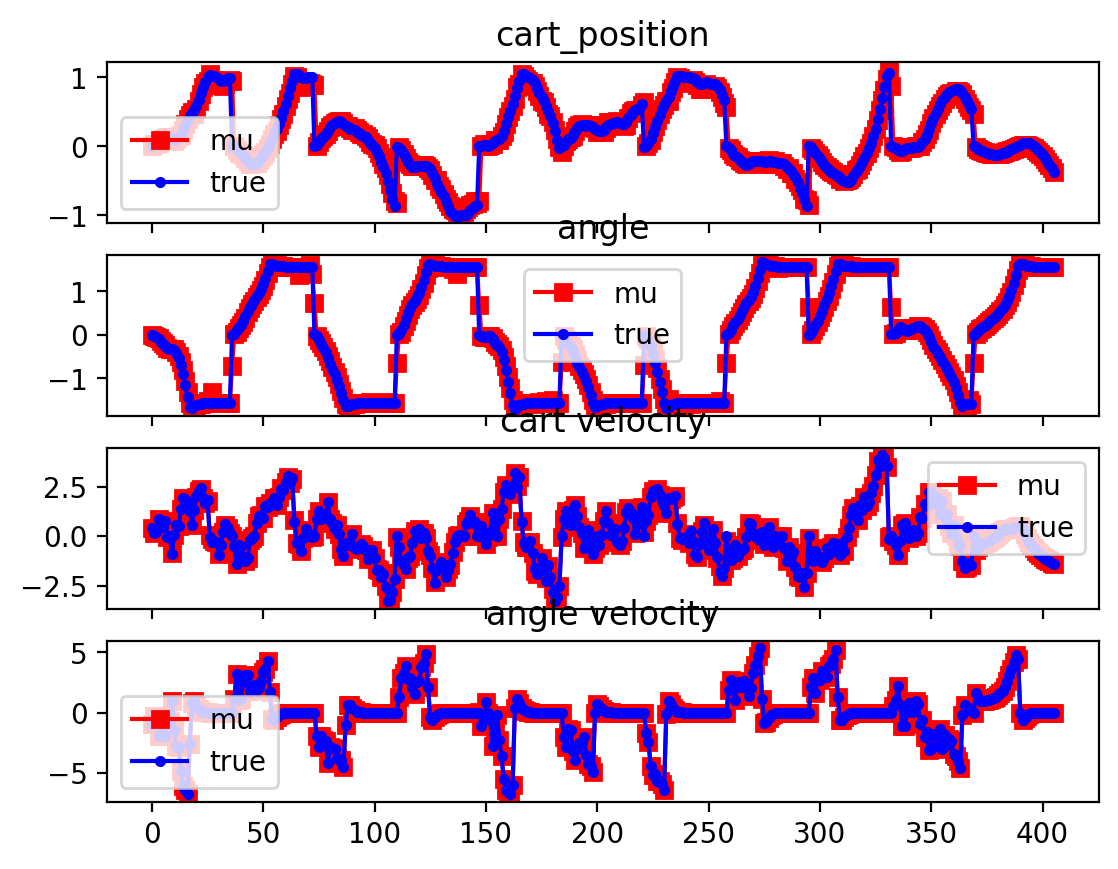

In [44]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

In [45]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [46]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [47]:
%%time
control_policy = fit_controller(
    policy=control_policy,
    samples=initial_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=1000
)

step=0, train_loss=386.8240701367683, 
step=100, train_loss=397.62845651024253, 
step=200, train_loss=397.6280058249208, 
step=300, train_loss=397.62651891236504, 
step=400, train_loss=397.6263596266745, 
step=500, train_loss=397.62619912284674, 
step=600, train_loss=397.62602584224123, 
step=700, train_loss=397.62584290951276, 
step=800, train_loss=397.62565300514024, 
step=900, train_loss=397.6254583943246, 
step=999, train_loss=397.6252629253034, 
CPU times: user 22min 44s, sys: 23min 44s, total: 46min 29s
Wall time: 7min 13s


In [50]:
st = jnp.array(states)

In [51]:
st.shape

(407, 4)

In [52]:
#cart_pos, pole_angle, cart_velocity, angle_velocity, _

Array([-0.00103511,  0.00864251,  0.00254091, -0.00607912], dtype=float64)

In [63]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,0.0)

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    print(x)
    print(timestep,r)
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)

[-0.01865825  0.04710616 -0.99001583  2.27769059]
0.0 1
[-0.05946646  0.13963324 -1.05152816  2.36435327]
0.01 1
[-0.10262402  0.23691802 -1.1072314   2.51463411]
0.02 0
[-0.14785465  0.34138272 -1.15482062  2.72243116]
0.03 0
[-0.1948576   0.45538721 -1.19530468  2.99039089]
0.04 0
[-0.2433598   0.5813707  -1.22900633  3.31970855]
0.05 0
[-0.29304554  0.72169993 -1.25347001  3.70567943]
0.06 0
[-0.34344068  0.87844786 -1.26329943  4.13866838]
0.07 0
[-0.39382108  1.05328295 -1.25151355  4.60852382]
0.08 0
[-0.44317958  1.24752865 -1.21110344  5.10846272]
0.09 0
[-0.49024965  1.46233061 -1.1363021   5.63628625]
0.1 0
[-0.53415692  1.63673074 -1.091307    1.4772193 ]
0.11 0
[-0.58008366  1.64189697 -1.20126416 -0.5736089 ]
0.12 0
[-0.63385242  1.61528188 -1.48623852 -0.6310894 ]
0.13 0
[-0.69753661  1.59483486 -1.69810693 -0.38782013]
0.14 0
[-0.76884884  1.58338265 -1.86756484 -0.1997161 ]
0.15 0
[-0.84618089  1.57773625 -1.99902308 -0.09413767]
0.16 0
[-0.92821959  1.57514231 -2.10287

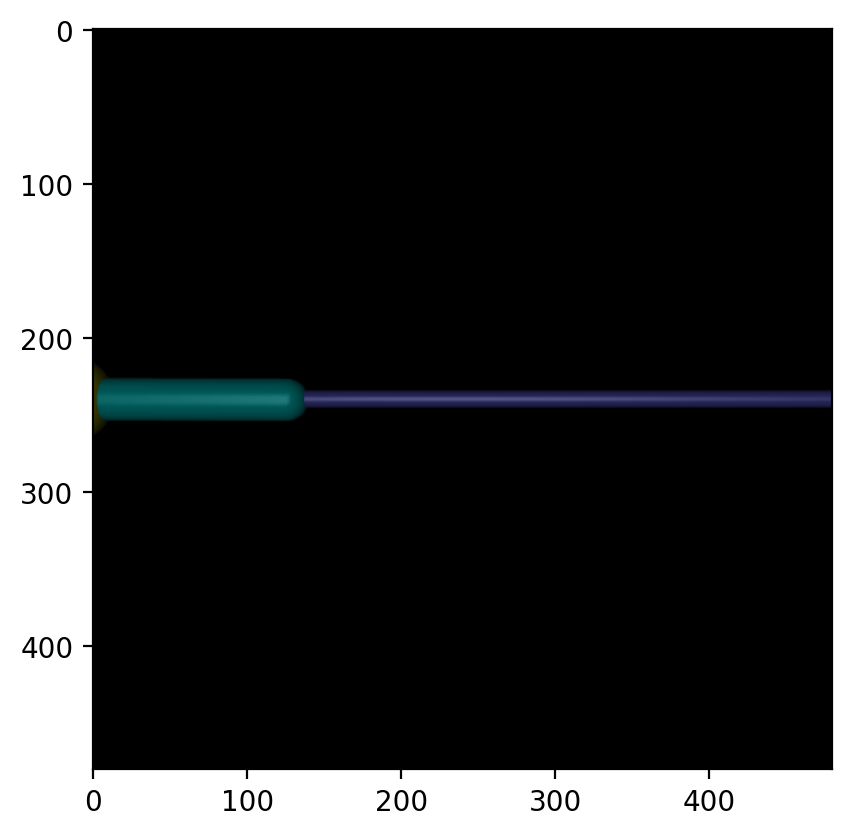

In [61]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    # states.append(x)
    # actions.append(u)
    print(x)
    print(timestep,r)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [39]:
model = DynamicalModel(states=jnp.array(states),actions=jnp.array(actions))
model.optimize()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
# Now do a rollout with this model
# Generate an initial state
x, _ = env.reset()
key, subkey = jr.split(key)
# Generate an initial (action
u = exploration_policy(x,timestep,subkey)

In [41]:
initial_particles = model.get_samples(key, jnp.array([x]), jnp.array([u]), num_particles)

In [42]:
objective_fun = Partial(rollout,init_samples=initial_particles,model=model,timesteps=timesteps)

In [43]:
%%time
policy,history = fit_controller(policy=policy,objective=objective_fun,optim=optimizer,num_iters=100)

CPU times: user 3min 26s, sys: 20 s, total: 3min 46s
Wall time: 2min 28s


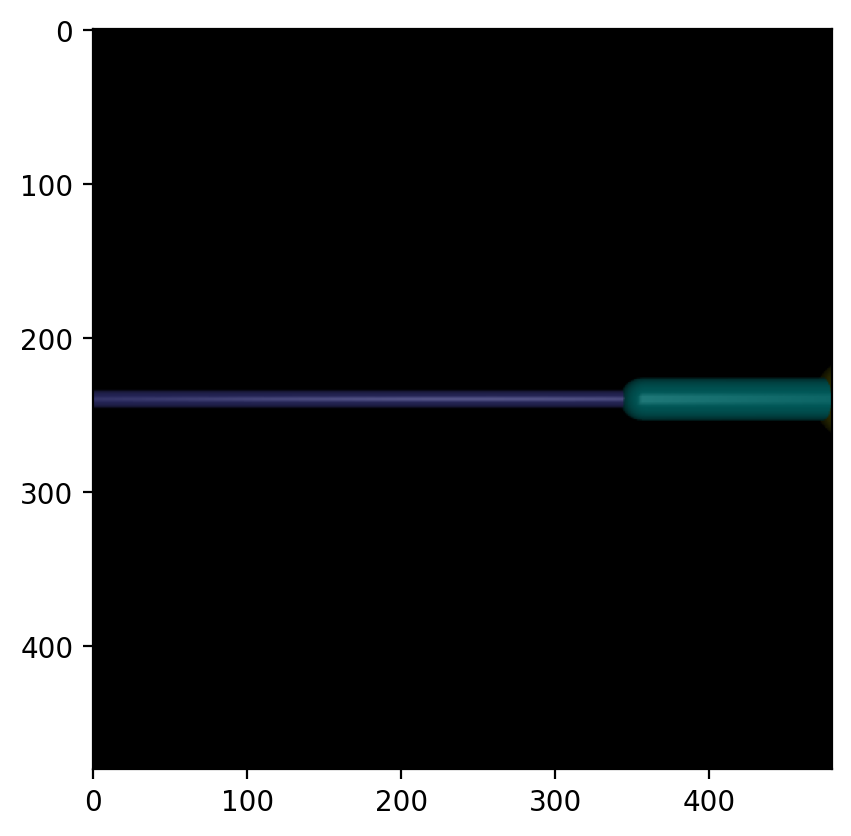

In [45]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = policy(x,timestep,subkey)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = policy(x,timestep,subkey)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [48]:
import random
import string

def generate_random_string(length):
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

random_string = generate_random_string(100)
print(random_string)

It01hSlVj40SnZLMTTIgZo46LwxLCVg7w28u7y0iquLeqvI6WEKApkgBfBgHk3BeZodKUnUFG9qoldAZbR3NZ4iREGfJrytkgmSr


In [49]:
random_string[-80:]

'Zo46LwxLCVg7w28u7y0iquLeqvI6WEKApkgBfBgHk3BeZodKUnUFG9qoldAZbR3NZ4iREGfJrytkgmSr'

In [49]:
np.random.uniform(-5, 5, (100, 2)).shape

(100, 2)

In [50]:
x_grid, y_grid = np.linspace(-5, 5, 100), np.linspace(-5, 5, 50)
x_, y_ = np.meshgrid(x_grid, y_grid)
X_pred = np.vstack((x_.flatten(), y_.flatten())).T

In [52]:
X_pred.shape

(5000, 2)